In [1]:
import findspark
findspark.init()

In [2]:
import pyspark.sql.functions as f
from pyspark.sql.functions import col, lit
from pyspark.sql import SparkSession

import seaborn as sns

In [3]:
spark = SparkSession.builder.appName("reddit").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/04 01:36:28 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.
22/05/04 01:36:39 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Attempted to request executors before the AM has registered!


In [4]:
spark

In [5]:
df = spark.read.parquet('s3://cn490-project/reddit')

# Clean data

### Timestamps

In [6]:
from pyspark.sql.functions import *
import pyspark.sql.functions as F
from pyspark.sql import Window
from pyspark.sql.types import IntegerType

df = df.withColumn("created_utc_ts", from_unixtime(col("created_utc"),"MM-dd-yyyy HH:mm:ss")) \
    .withColumn("author_created_utc_ts", from_unixtime(col("author_created_utc"),"MM-dd-yyyy HH:mm:ss")) \

In [7]:
# Get Date
df = df.withColumn("created_date", to_date(to_timestamp("created_utc_ts",'MM-dd-yyyy HH:mm:ss'))) \
        .withColumn("author_created_date", to_date(to_timestamp("author_created_utc_ts",'MM-dd-yyyy HH:mm:ss'))) \

In [8]:
# Get Time
df = df.withColumn("created_time", date_format(to_timestamp("created_utc_ts",'MM-dd-yyyy HH:mm:ss'), 'HH:mm:ss')) \
    .withColumn("author_created_time", date_format(to_timestamp("author_created_utc_ts",'MM-dd-yyyy HH:mm:ss'), 'HH:mm:ss')) \

In [9]:
# Get Hour
df = df.withColumn("created_hour", hour(to_timestamp("created_utc_ts",'MM-dd-yyyy HH:mm:ss'))) \
        .withColumn("author_created_hour", hour(to_timestamp("author_created_utc_ts",'MM-dd-yyyy HH:mm:ss')))

### Feature engineering

In [10]:
# Account age in days
df = df.withColumn("acc_age_days", (col("created_utc") - col("author_created_utc"))/86400)

# Log transform
df = df.withColumn("log_age", log(df.acc_age_days+1)).fillna(0,subset=['log_age'])

In [11]:
# Account created hour minus post created hour 
df = df.withColumn("diff_created", pow(col("created_hour")-col("author_created_hour"),2)).fillna(-1, subset=['diff_created'])

In [12]:
# Removed body
df = df.withColumn("rm_body", F.when(col("body")=="[removed]",True).otherwise(False))
# Deleted Body
df = df.withColumn("deleted_body", F.when(col("body")=="[deleted]",True).otherwise(False))

# Negative score
df = df.withColumn("neg_score", F.when(col("score") < 0, True).otherwise(False))

# Post got deleted
df = df.withColumn("deleted_post", F.when(col("author")=="[deleted]",True).otherwise(False))

# Comment collapsed because low score
df = df.withColumn("low_score", F.when(col("collapsed_reason").isNotNull(),True).otherwise(False))

# Has flair
df = df.withColumn("has_flair", F.when(col("author_flair_text").isNotNull(),True).otherwise(False))

# Is moderator
df = df.withColumn("is_mod", F.when(col("distinguished")=='moderator',True).otherwise(False))

In [13]:
# Day of week and posted on weekend
df = df.withColumn('day_of_week', date_format("created_date", "EEEE")) \
        .withColumn("posted_on_weekend", 
                F.when(
                    (date_format("created_date", "EEEE") =='Sunday')| \
                    (date_format("created_date", "EEEE") =='Saturday') \
                     ,1).otherwise(0)) 


In [14]:
df = df.fillna({'edited':False})

# Recast boolean to integer
df = df.withColumn('is_submitter', df.is_submitter.cast(IntegerType())) \
        .withColumn('deleted_post', df.deleted_post.cast(IntegerType())) \
        .withColumn('neg_score', df.neg_score.cast(IntegerType())) \
        .withColumn('has_flair', df.has_flair.cast(IntegerType())) \
        .withColumn('locked', df.locked.cast(IntegerType())) \
        .withColumn('can_gild', df.can_gild.cast(IntegerType())) \
        .withColumn('can_mod_post', df.can_mod_post.cast(IntegerType())) \
        .withColumn('edited', df.edited.cast(IntegerType())) \
        .withColumn('stickied', df.stickied.cast(IntegerType())) \
        .withColumn('gilded', df.gilded.cast(IntegerType())) \
        .withColumn('low_score', df.low_score.cast(IntegerType())) \
        .withColumn('send_replies', df.send_replies.cast(IntegerType())) \
        .withColumn('rm_body', df.rm_body.cast(IntegerType())) \
        .withColumn('deleted_body', df.deleted_body.cast(IntegerType())) 

In [15]:
# Number of comments by same author in thread
df = df.withColumn('user_comments_in_thread', F.count('id').over(Window.partitionBy('link_id', 'author')))

# Total score by same author in thread
df = df.withColumn('user_score_in_thread', F.sum('score').over(Window.partitionBy('link_id', 'author')))

# Number of total comments in thread
df = df.withColumn('thread_total_comments', F.count('id').over(Window.partitionBy('link_id')))

In [16]:
# Number of distinct users in thread

df = df.withColumn('users_in_thread', F.approx_count_distinct('author').over(Window.partitionBy('link_id')))

### Tokenize text columns

In [17]:
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType

tokenizer = Tokenizer(inputCol="body", outputCol="tokenized_body")

countTokens = udf(lambda words: len(words), IntegerType())
df = tokenizer.transform(df)

In [18]:
df = df.withColumn("comment_length", countTokens(col("tokenized_body"))) 

In [19]:
# replace null with empty string
df = df.fillna({'author_flair_text':" "})

flair_tokenizer = Tokenizer(inputCol="author_flair_text", outputCol="tokenized_flair")
df = flair_tokenizer.transform(df)

In [20]:
df = df.withColumn("flair_length", size(col("tokenized_flair")))

## Classifier for is_submitter

In [21]:
data = df.select('is_submitter',
                 'day_of_week',
                 'score','log_age',
                 'deleted_post','neg_score','diff_created',
                 'has_flair','comment_length','flair_length','is_mod',
                 'user_comments_in_thread','user_score_in_thread','users_in_thread','thread_total_comments',
                 'can_gild','can_mod_post','edited','stickied','locked','gilded',
                 'rm_body','deleted_body','send_replies'
                )

data.createOrReplaceTempView("data")

22/05/04 01:36:51 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [22]:
data.printSchema()

root
 |-- is_submitter: integer (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- score: long (nullable = true)
 |-- log_age: double (nullable = false)
 |-- deleted_post: integer (nullable = false)
 |-- neg_score: integer (nullable = false)
 |-- diff_created: double (nullable = false)
 |-- has_flair: integer (nullable = false)
 |-- comment_length: integer (nullable = true)
 |-- flair_length: integer (nullable = false)
 |-- is_mod: boolean (nullable = false)
 |-- user_comments_in_thread: long (nullable = false)
 |-- user_score_in_thread: long (nullable = true)
 |-- users_in_thread: long (nullable = false)
 |-- thread_total_comments: long (nullable = false)
 |-- can_gild: integer (nullable = true)
 |-- can_mod_post: integer (nullable = true)
 |-- edited: integer (nullable = true)
 |-- stickied: integer (nullable = true)
 |-- locked: integer (nullable = true)
 |-- gilded: integer (nullable = true)
 |-- rm_body: integer (nullable = false)
 |-- deleted_body: integer (nullabl

In [23]:
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)
print("Number of training records: " + str(train_data.count()))
print("Number of testing records : " + str(test_data.count()))

Number of training records: 7141851


Number of testing records : 1786550


# Load trained model

In [24]:
from pyspark.ml import PipelineModel

model = PipelineModel.load("s3://cn490-project/model_location/gbt_big_f2")

# Predict on training

In [26]:
prediction_train = model.transform(train_data)

In [28]:
y_pred_train=prediction_train.select("prediction").collect()
y_orig_train=prediction_train.select("indexedLabel").collect()

# Predict on test

In [29]:
prediction_test = model.transform(test_data)
y_pred_test=prediction_test.select("prediction").collect()
y_orig_test=prediction_test.select("indexedLabel").collect()

## Confusion matrix training

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
cm_train = confusion_matrix(y_orig_train, y_pred_train)

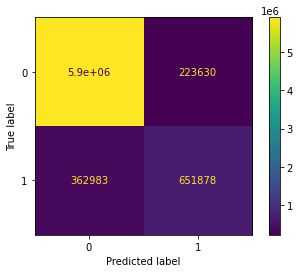

In [62]:
import matplotlib.pyplot as plt
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp.plot()

plt.savefig('confusion_matrix_train.png')
plt.show()


# Confusion matrix test

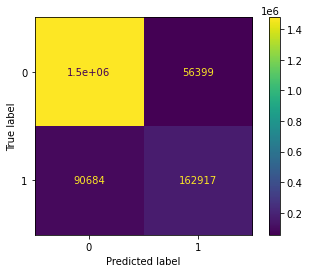

In [63]:
cm_test = confusion_matrix(y_orig_test, y_pred_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp.plot()

plt.savefig('confusion_matrix_test.png')
plt.show()


In [49]:
model.stages

[StringIndexerModel: uid=StringIndexer_919dee725947, handleInvalid=error,
 OneHotEncoderModel: uid=OneHotEncoder_5f4e32f6589e, dropLast=true, handleInvalid=error,
 StringIndexerModel: uid=StringIndexer_1b4ecdf44d48, handleInvalid=error,
 VectorAssembler_0e1a11f68fcb,
 GBTClassificationModel: uid = GBTClassifier_95fb482f933d, numTrees=20, numClasses=2, numFeatures=28,
 IndexToString_d0eb27c30aa8]

### Feature Importance

In [50]:
# Print out the stages of the best model
model.stages

[StringIndexerModel: uid=StringIndexer_919dee725947, handleInvalid=error,
 OneHotEncoderModel: uid=OneHotEncoder_5f4e32f6589e, dropLast=true, handleInvalid=error,
 StringIndexerModel: uid=StringIndexer_1b4ecdf44d48, handleInvalid=error,
 VectorAssembler_0e1a11f68fcb,
 GBTClassificationModel: uid = GBTClassifier_95fb482f933d, numTrees=20, numClasses=2, numFeatures=28,
 IndexToString_d0eb27c30aa8]

In [52]:
# get the vector assembler
va = model.stages[-3]
# get the tree
tree = model.stages[-2]

fe = list(zip(va.getInputCols(), tree.featureImportances))

In [53]:
fe

[('day_of_week_vec', 0.0),
 ('score', 0.0),
 ('log_age', 0.0),
 ('deleted_post', 0.0),
 ('neg_score', 0.0),
 ('diff_created', 0.0),
 ('has_flair', 0.01987071708663891),
 ('comment_length', 0.002878690852083281),
 ('flair_length', 0.15019984498533198),
 ('is_mod', 0.0),
 ('user_comments_in_thread', 0.0),
 ('user_score_in_thread', 0.02352039759588642),
 ('users_in_thread', 0.024391518880899677),
 ('thread_total_comments', 0.026315165234549454),
 ('can_gild', 4.6491821896243534e-05),
 ('can_mod_post', 0.29896794419363676),
 ('edited', 0.03809851345760095),
 ('stickied', 0.1465266400650838),
 ('locked', 0.269129056796844),
 ('gilded', 0.0),
 ('rm_body', 0.0),
 ('deleted_body', 5.5019029548509814e-05),
 ('send_replies', 0.0)]

In [55]:
import pandas as pd
fe = pd.DataFrame(fe, columns =['feature', 'importance'])

In [61]:
fe.sort_values(by='importance', ascending=False)

,feature,importance
15,can_mod_post,0.298968
18,locked,0.269129
8,flair_length,0.150200
17,stickied,0.146527
16,edited,0.038099
13,thread_total_comments,0.026315
12,users_in_thread,0.024392
11,user_score_in_thread,0.023520
6,has_flair,0.019871
7,comment_length,0.002879


In [65]:
display(tree)

GBTClassificationModel: uid = GBTClassifier_95fb482f933d, numTrees=20, numClasses=2, numFeatures=28

In [44]:
spark.stop()